# Neural networks

In [1]:
import torch
import torch.nn as nn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.widgets import Button, Slider
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split
from torch.optim.lr_scheduler import StepLR
import copy
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix
import seaborn as sns

### First we can look at how build a neural network and train it using our simple linear regression example

In [2]:
df = pd.read_csv('income_data.csv')

In [3]:
layer = nn.Linear(1, 2)

samples = df.sample(n=50,random_state=0)

# we have to convert our data into Pytorch Tensors 
# we also need to add another dimension for vectors
x = torch.tensor(np.array(samples["income"])[:, None].astype(np.float32))
print('x.shape', x.shape)

y = layer(x)
print('y.shape', y.shape)

x.shape torch.Size([50, 1])
y.shape torch.Size([50, 2])


In [4]:
# we can define a very simple network - we will look at exactly what this means later

f = nn.Sequential(nn.Linear(1, 4), 
                  nn.ReLU(), 
                  nn.Linear(4, 1))

x = torch.linspace(np.min(samples["income"]), np.max(samples["income"]), 100)[:, None] # don't forget to add an extra dimension
y = f(x)  # evaluate the network (with random weights!)

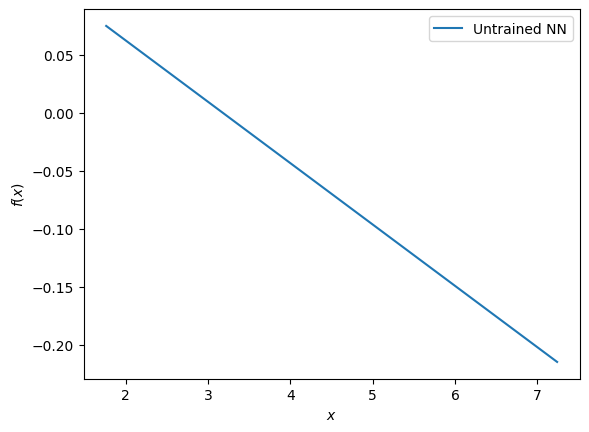

In [5]:
# visualise untrained network
fig, ax = plt.subplots()
ax.plot(x, y.detach().numpy(), label='Untrained NN')
ax.set_xlabel(r'$x$')
ax.set_ylabel(r'$f(x)$')
ax.legend();

In [6]:
# this is our training data that we will use to evualuate the performance of our network

X = torch.tensor(np.array(df["income"])[:, None].astype(np.float32))
Y = torch.tensor(np.array(df["happiness"])[:, None].astype(np.float32))

X.shape, Y.shape

(torch.Size([498, 1]), torch.Size([498, 1]))

We are using a mean squared error loss function, like how we defined errors in the linear regression notebook. Write a function that returns this error in the cell below

$$
\mathcal{L}(\mathbf{w}) = \frac{1}{n}\sum_{i=1}^n \left(y_i-f({x}_i;\mathbf{w})\right)^2
$$

HINT: use the torch.mean() function

In [7]:
#INTERACTIVE

def mse_loss(y, f):
    return torch.mean( (y - f)**2 )

In [8]:
torch.manual_seed(0) # reproducible weights
optimizer = torch.optim.SGD(f.parameters(), lr=0.001) # lr is the learning rate
training_loss_lin = [] # save history for visualisation later
predictions = []

# Iterate the optimizer
pbar = range(100)
for i in pbar:
    optimizer.zero_grad()        # must be done for optimizer to work correctly
    Y_pred = f(X)                # Make predictions
    predictions.append(Y_pred)
    loss = mse_loss(Y, Y_pred)   # Evaluate loss
    loss.backward()              # Evaluate gradient of loss wrt parameters
    optimizer.step()             # Update weights using gradient
    training_loss_lin.append(loss.item()) # Save the training loss for visualization
    # pbar.set_description(f"loss = {loss.item():1.3f}") 

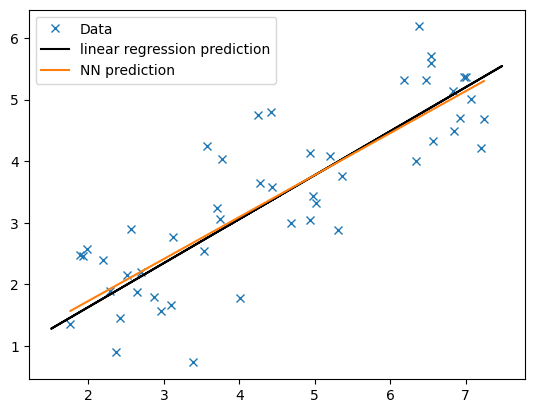

In [9]:
# visualise model predictions
fig, ax = plt.subplots()
# ax.plot(df["income"], df["happiness"], 'x', label='Data');
ax.plot(samples["income"], samples["happiness"], 'x', label='Data');
# xx = torch.linspace(np.min(samples["income"]), np.min(samples["happiness"]), 100)[:, None]
xx = torch.linspace(np.min(samples["income"]), np.max(samples["income"]), 100)[:, None]
yy = f(xx).detach().numpy()
plt.plot(df["income"], 0.20427039620417675 + 0.7138255122802075*df["income"], 'black', label='linear regression prediction')
ax.plot(xx, yy, label='NN prediction')
ax.legend();

We can see that the error is getting smaller each step until it converges

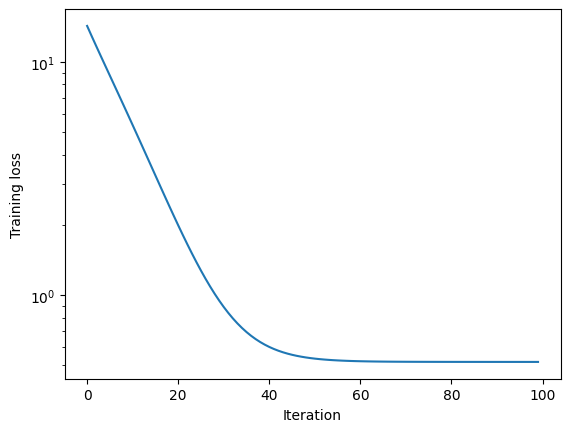

In [10]:
# plot loss
fig, ax = plt.subplots()
ax.semilogy(training_loss)
ax.set_xlabel('Iteration')
ax.set_ylabel('Training loss');

And we can see how the prediction is updated at each step too

Talk about the time taken for linear least squares as the number of parameters increases to justify why we would use a neural network instead. 

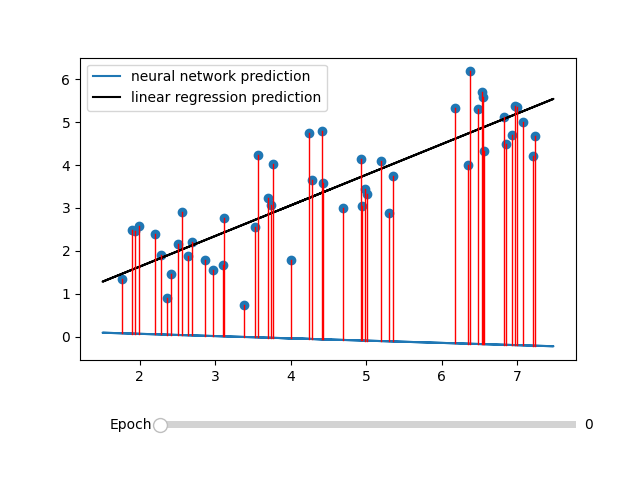

In [33]:
# plot prediction at each epoch 

def connect_best_fit(ax, x, y, slope, intercept):
    # remove red lines from previous step
    [r.remove() for r in ax.lines if r.get_color() == 'red']
    # Plot new residuals
    for i in range(len(y)):
        y_opt = slope * x[i] + intercept
        ax.plot([x[i], x[i]], [y_opt, y[i]], color='red', linewidth=1)
    return
    
%matplotlib widget

fig, ax = plt.subplots()
fig.subplots_adjust(bottom=0.25)
l, = ax.plot(df["income"],predictions[0].detach().numpy(), label='neural network prediction')
ax.plot(df["income"], 0.20427039620417675 + 0.7138255122802075*df["income"], 'black', label='linear regression prediction')
ax.scatter(samples["income"],samples["happiness"])

#approximate slope and intercept for linear fit
x = np.asarray(df["income"]).ravel().astype(float)
y_pred = np.asarray(predictions[0].detach().numpy()).ravel().astype(float)

# compute slope and intercept using least squares
slope = np.cov(x, y_pred, bias=True)[0, 1] / np.var(x)
intercept = np.mean(y_pred) - slope * np.mean(x)

# connect_best_fit(ax,x,y,slope,intercept)
connect_best_fit(ax,np.array(samples["income"]),np.array(samples["happiness"]),slope,intercept)

ax_num = fig.add_axes([0.25, 0.1, 0.65, 0.03])

# define the values to use for snapping
num_epochs = np.arange(0, 100)

s_num = Slider(
    ax_num, "Epoch", 0, 100,
    valinit=0, valstep=num_epochs,
    color="green"
)

def update(val):
    num = s_num.val
    l.set_ydata(predictions[num].detach().numpy())
    
    x = np.asarray(df["income"]).ravel().astype(float)
    y_pred = np.asarray(predictions[num].detach().numpy()).ravel().astype(float)
    
    # compute slope and intercept using least squares
    slope = np.cov(x, y_pred, bias=True)[0, 1] / np.var(x)
    intercept = np.mean(y_pred) - slope * np.mean(x)
    # connect_best_fit(ax,x,y,slope,intercept)
    connect_best_fit(ax,np.array(samples["income"]),np.array(samples["happiness"]),slope,intercept)
    error = training_loss_lin[num]
    ax.set_title(f"Error: {error}")
    fig.canvas.draw_idle()

s_num.on_changed(update)

ax.legend()
plt.show()

<img align="center" width="70%" src="SupervisedOpt.svg">

<small>*Image taken from from Understanding Deep Learning, Prince 2022. This work is subject to a Creative Commons CC-BY-NC-ND license. (C) MIT Press.*</small>

So now we see the final prediction and how at each step the error becomes smaller and smaller until it no longer changes


So we can see that each time the prediction is slightly different. To understand why let's first understand how the network works. 

### How do we get the prediction from the trained neural network?

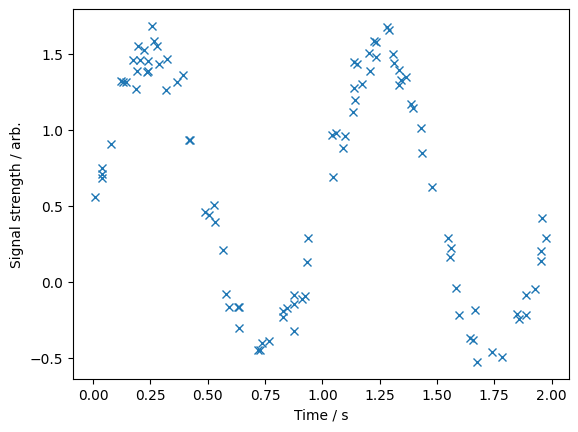

In [12]:
plt.close()

%matplotlib inline

np.random.seed(0)
torch.manual_seed(0)

def noise(size, variance):
    return np.random.normal(scale=np.sqrt(variance), size=size)

def g(X, noise_variance):
    """
    Sinus function plus noise
    """
    return 0.5 + np.sin(2*np.pi*X) + noise(X.shape, noise_variance)

# generate some sample data
# X_g = np.random.uniform(0, 2, size=100)[:, None]
# Y_g = g(X_g, noise_variance=0.1**2)

X_g = np.random.uniform(0, 2, size=100)[:, None].astype(np.float32)  # (100,1)
Y_g = g(X_g, noise_variance=0.1**2).astype(np.float32) 
X, Y = X_g, Y_g # save for later

# plotting code
plt.plot(X, Y, 'x', label='Observations')
plt.xlabel("Time / s")
plt.ylabel("Signal strength / arb.")
plt.show()

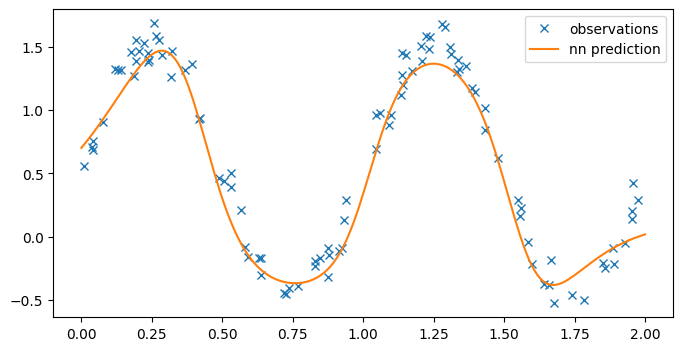

In [13]:
# convert to torch tensors for training (targets are plain tensors, no grad)
X = torch.from_numpy(X_g)   # dtype torch.float32
Y = torch.from_numpy(Y_g)

# Simple network
f = nn.Sequential(
    nn.Linear(1, 3),
            nn.Tanh(),
            nn.Linear(3, 2),
            nn.Tanh(),
            # nn.Tanh(),
            nn.Linear(2, 1)
        )

optimizer = torch.optim.SGD(f.parameters(), lr=1e-1)
training_loss = []

# training loop
for epoch in range(30000):
    optimizer.zero_grad()
    Y_pred = f(X)               # shape (100,1)
    loss = mse_loss(Y, Y_pred)  # Y is a plain tensor (no grad history)
    loss.backward()
    optimizer.step()
    training_loss.append(loss.item())

# plot data and fit
xx = torch.linspace(0, 2, 200)[:, None]
yy = f(xx).detach().numpy()

plt.figure(figsize=(8,4))
plt.plot(X.numpy(), Y.numpy(), 'x', label='observations')
plt.plot(xx.numpy(), yy, '-', label='nn prediction')
plt.legend()
plt.show()


Our prediction isn't a perfect fit as we are limited by using a small network in this example for visualisation purposes. 

We can print out all the parameters that our final trained network has learned. 

In [14]:
params = []
for name, param in f.named_parameters():
    print(name, param.shape)
    print(param.detach().numpy())
    params.append(param.view(-1))

params = torch.cat(params)
print(params.shape)

0.weight torch.Size([3, 1])
[[ 4.946112 ]
 [ 2.8450227]
 [-2.2187898]]
0.bias torch.Size([3])
[-4.969349   -5.1715345   0.25372878]
2.weight torch.Size([2, 3])
[[-1.3199476   4.43718    -4.6886024 ]
 [-0.18778391  0.8187624  -0.9304951 ]]
2.bias torch.Size([2])
[0.03970702 0.3000282 ]
4.weight torch.Size([1, 2])
[[-1.6500671  1.8665321]]
4.bias torch.Size([1])
[0.00281721]
torch.Size([17])


But how is the prediction made? Let's go through an example to see if we can predict the output for x=1.5.

In [15]:
xx = torch.tensor([[1.5]], dtype=torch.float32)
yy = f(xx).detach().numpy()

print(xx)
print(yy)

# now calculating it manually on paper: 

tensor([[1.5000]])
[[0.4368988]]


Mathematically, we can define our network as follows

\begin{align}
h_1 = tanh(\beta_0 + W_0 x)\\
h_2 = tanh(\beta_1 + W_1 h_1)\\
y = \beta_2 + W_2 h_2
\end{align}

 <img align="center" width="70%" src="neural_network.png">

Create an animation where I show how the neural network prediction changes at each layer

The activation functions are how we get non-linearity. 

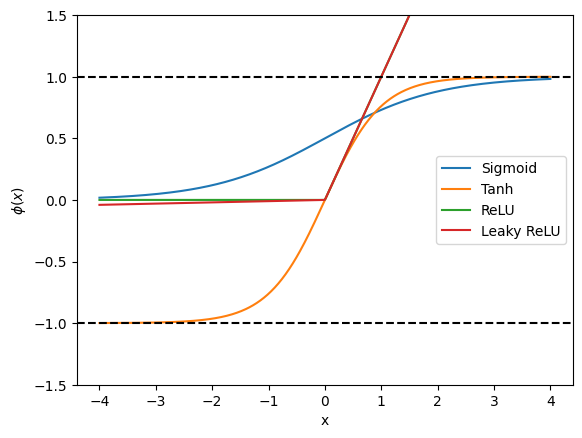

In [16]:
# show common activation functions

# Visualise activation functions
x = torch.linspace(-4, 4, 500)
fig, ax = plt.subplots()
ax.plot(x, nn.Sigmoid()(x), label='Sigmoid')
ax.plot(x, nn.Tanh()(x), label='Tanh')
ax.plot(x, nn.ReLU()(x), label='ReLU')
ax.plot(x, nn.LeakyReLU()(x), label='Leaky ReLU')
ax.set_ylim(-1.5, 1.5)
for y in [-1,1]:
    ax.axhline(y, color='k', linestyle='dashed')
ax.set_xlabel('x')
ax.set_ylabel(r'$\phi(x)$')
ax.legend();

In the cell below, write a function that gives tanh(x)

$$
tanh(x) = \frac{exp(x)-exp(-x)}{exp(x)+exp(x)}
$$

In [17]:
# INTERACTIVE

def tanh(x):

    return (np.exp(x)-np.exp(-x))/(np.exp(x)+np.exp(-x))
    
np.round(tanh(0.453481732),decimals=6)

0.424757

## How do we actally train the neural network?

### Gradient descent

We have already seen an example where the error of the loss function decreases at each step until convergence but this doesn't work for every example. 

Step 1:

Compute the derivatives of the loss with respect to the parameters:

$$
\frac{\partial L}{\partial \phi} = \begin{bmatrix}
\frac{\partial L}{\partial \phi_0} \\
\frac{\partial L}{\partial \phi_1} \\
\vdots \\
\frac{\partial L}{\partial \phi_N}
\end{bmatrix}
$$

This first step computes the gradient of the loss function at the current position, this determines the uphill direction of the loss function. 

Step 2:

Update the parameters according to the rule

$$
\phi \leftarrow \phi - \alpha \cdot \frac{\partial L}{\partial \phi}
$$

where the positive scalar determines the magnitude of the change. This second step moves a small distace (alpha) downhill (hence the negative sign). 

### Backpropagation

This refers to the algorithm used to compute the derivates used for gradient descent. We can break it down into two steps:

1) Forward pass 
2) Backward pass

Go through algebra using network above with 17 tunable parameters

\begin{align}
h_1 = tanh(\beta^0 + W^0 x)\\
h_2 = tanh(\beta^1 + W^1 h_1)\\
f = \beta^2 + W^2 h_2
\end{align}

We can also define our mean-squared loss function as 

$$
L[\phi] = \sum_{i=1}^N(f_i - y_i)^2
$$

There are 17 different tunable parameters: $\phi = {\beta^0_0,\beta^0_1,\beta^0_2,W^0_0,W^0_1,W^0_2,\beta^1_0,\beta^1_1,W^1_0,W^1_1,W^1_2,W^1_3,W^1_4,W^1_5,\beta^2,W^2_0,W^2_1}$

We need to compute the derivate of the loss w.r.t. all of the above parameters. 

First, we can use the initial parameters to calculate the 'forward pass' - loss with those values - we went through this above. 

We can break up our network definition as

\begin{align}
f_0 = \beta^0 + W^0 x \\
h_1 = tanh(f_0)
f_1 = \beta^1 + W^1 h_1 \\
h_2 = tanh(f_1) \\
h_3 = \beta^2 + W^2 h_2 
\end{align}


Can speak a bit about how this is actually done - for example the use of GPUs and autograd for differentiation. 

In [18]:
phi_0 = -5.0 # default values for phi
phi_1 = 25.0

def noise(size, variance):
    return np.random.normal(scale=np.sqrt(variance), size=size)

def g(X, noise_variance=0.0, phi=None):
    if phi is None:
        phi = (phi_0, phi_1)
    t = phi[0] + 0.06 * phi[1] * X
    return np.sin(t) * np.exp(-t**2 / 32) + noise(X.shape, noise_variance)

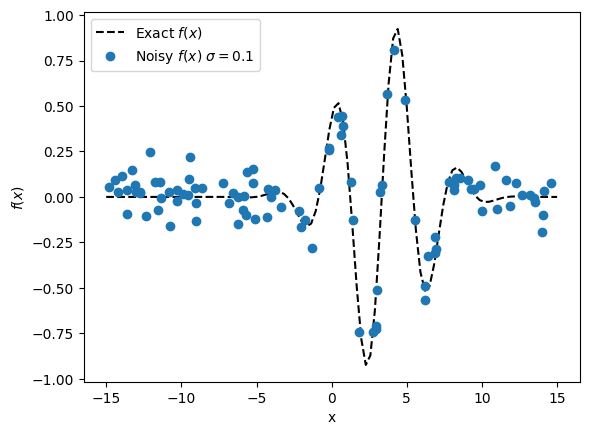

In [19]:
#plotting code
fig, ax = plt.subplots()
sigma = 0.1
x = np.linspace(-15, 15, 100)

n = 100
np.random.seed(42)
x_g = np.random.uniform(-15, 15, n)
y_g = g(x_g, sigma**2)

ax.plot(x, g(x, 0), 'k--', label='Exact $f(x)$')
ax.plot(x_g, y_g, 'o', label=f'Noisy $f(x)$ $\sigma={sigma}$')
ax.set_xlabel('x')
ax.legend()
ax.set_ylabel('$f(x)$');

In [20]:
layer = nn.Linear(1, 4)

x = torch.tensor(x_g[:, None].astype(np.float32))
print('x.shape', x.shape)

y = layer(x)
print('y.shape', y.shape)

f = nn.Sequential(    # so we can add labels for visualisation
        (nn.Linear(1, 8)),    # input layer
        (nn.ReLU()),          # activation function
        (nn.Linear(8, 8)),    # 1st hidden layer
        (nn.ReLU()),          # activation function
        (nn.Linear(8, 8)),    # 2nd hidden layer
        (nn.Linear(8, 1))     # linear output layer
        )

x = torch.linspace(-15, 15, 100)[:, None] # don't forget to add an extra dimension
y = f(x)  # evaluate the network (with random weights!)

X = torch.tensor(x_g[:, None].astype(np.float32))
Y = torch.tensor(y_g[:, None].astype(np.float32))

x.shape torch.Size([100, 1])
y.shape torch.Size([100, 4])


In [21]:
# Initialize the optimizer with parameters from our DNN f(x)
optimizer = torch.optim.SGD(f.parameters(), lr=0.01) # lr is the learning rate
training_loss = [] # save history for visualisation later

# Iterate the optimizer
pbar = range(5000)
for i in pbar:
    optimizer.zero_grad()        # must be done for optimizer to work correctly
    Y_pred = f(X)                # Make predictions
    loss = mse_loss(Y, Y_pred)   # Evaluate loss
    loss.backward()              # Evaluate gradient of loss wrt parameters
    optimizer.step()             # Update weights using gradient
    training_loss.append(loss.item()) # Save the training loss for visualization
    # pbar.set_description(f"loss = {loss.item():1.3f}")

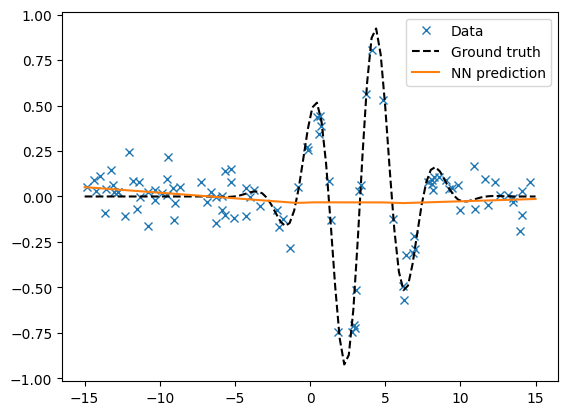

In [22]:
# gradient descent

# visualise model predictions
fig, ax = plt.subplots()
ax.plot(x_g, y_g, 'x', label='Data');
xx = torch.linspace(-15, 15, 100)[:, None]
yy = f(xx).detach().numpy()
ax.plot(xx, g(xx), 'k--', label='Ground truth')
ax.plot(xx, yy, label='NN prediction')
ax.legend();

### Stochastic gradient descent 

We can see that the loss function is stuck in a local minimus - but this doesn't model the true function very well. 

SGD involves splitting up the training dataset into batches, and computing the loss function for each one.
Therefore, the parameters can be updated accordingly, until the full training set has been sampled (one
epoch). One other advantage of SGD is that it is computationally cheaper to compute the gradients of the batches.
It also seems like SGD helped generalisation to new data (so prevents overtraining). Normally, SGD is applied with a learning rate schedule - a large alpha at first which decreases by a constant
factor every N epochs (for fine-tuning).



In [23]:
batch_size = 5
x = x_g[:, None]
y = y_g[:, None]

# partition into 70% training data, 30% test with fixed random seed for reproducibility
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=42)

train_data = TensorDataset(torch.Tensor(x_train), torch.Tensor(y_train))
train_loader = DataLoader(train_data, batch_size=batch_size)

test_data = TensorDataset(torch.Tensor(x_test), torch.Tensor(y_test))
test_loader = DataLoader(test_data, batch_size=batch_size)

print(f'Training set: contains {len(train_data)} obs. in '
      f'{len(train_loader)} batches of size {batch_size}.')

print(f'Test set:     contains {len(test_data)} obs. in '
      f'{len(test_loader)} batches of size {batch_size}.')

dummy_x, dummy_y = next(iter(train_loader)) # pull first batch from loader
print(dummy_x.shape)
print(dummy_y.shape)  

Training set: contains 70 obs. in 14 batches of size 5.
Test set:     contains 30 obs. in 6 batches of size 5.
torch.Size([5, 1])
torch.Size([5, 1])


In [24]:
learning_rate = 0.05

torch.manual_seed(1) # reproducible weights
model = nn.Sequential(nn.Linear(1, 64),                # Re-define model (new random weights)
                  nn.ReLU(), nn.Linear(64, 32),
                  nn.ReLU(), nn.Linear(32, 32),
                  nn.Linear(32, 1))
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    total_loss = 0.0
    for batch, (x, y) in enumerate(dataloader):
        optimizer.zero_grad()        
        y_pred = model(x)
        loss = loss_fn(y, y_pred)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    train_err = total_loss/num_batches
    return train_err

def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss = 0.0
    with torch.no_grad():
        for x, y in dataloader:
            pred = model(x)
            test_loss += loss_fn(pred, y).item()
    test_err = test_loss / num_batches
    return test_err

test(train_loader, model, mse_loss)

0.18938042223453522

In [25]:
log = []
checkpoints = []
min_test_err = np.inf

pbar = range(4000)
for epoch in pbar:
    train_err = train(train_loader, model, mse_loss, optimizer)
    test_err  = test(test_loader, model, mse_loss)
    log.append([train_err, test_err])
    if test_err < min_test_err:
        min_test_err = test_err
        best_epoch = epoch
        best_model = copy.deepcopy(model.state_dict())
    # pbar.set_description(f"{epoch=:5d} Training Loss {train_err:>8f} Test Loss {test_err:>8f}")
    if epoch % 500 == 0:
        checkpoints.append(copy.deepcopy(model.state_dict()))

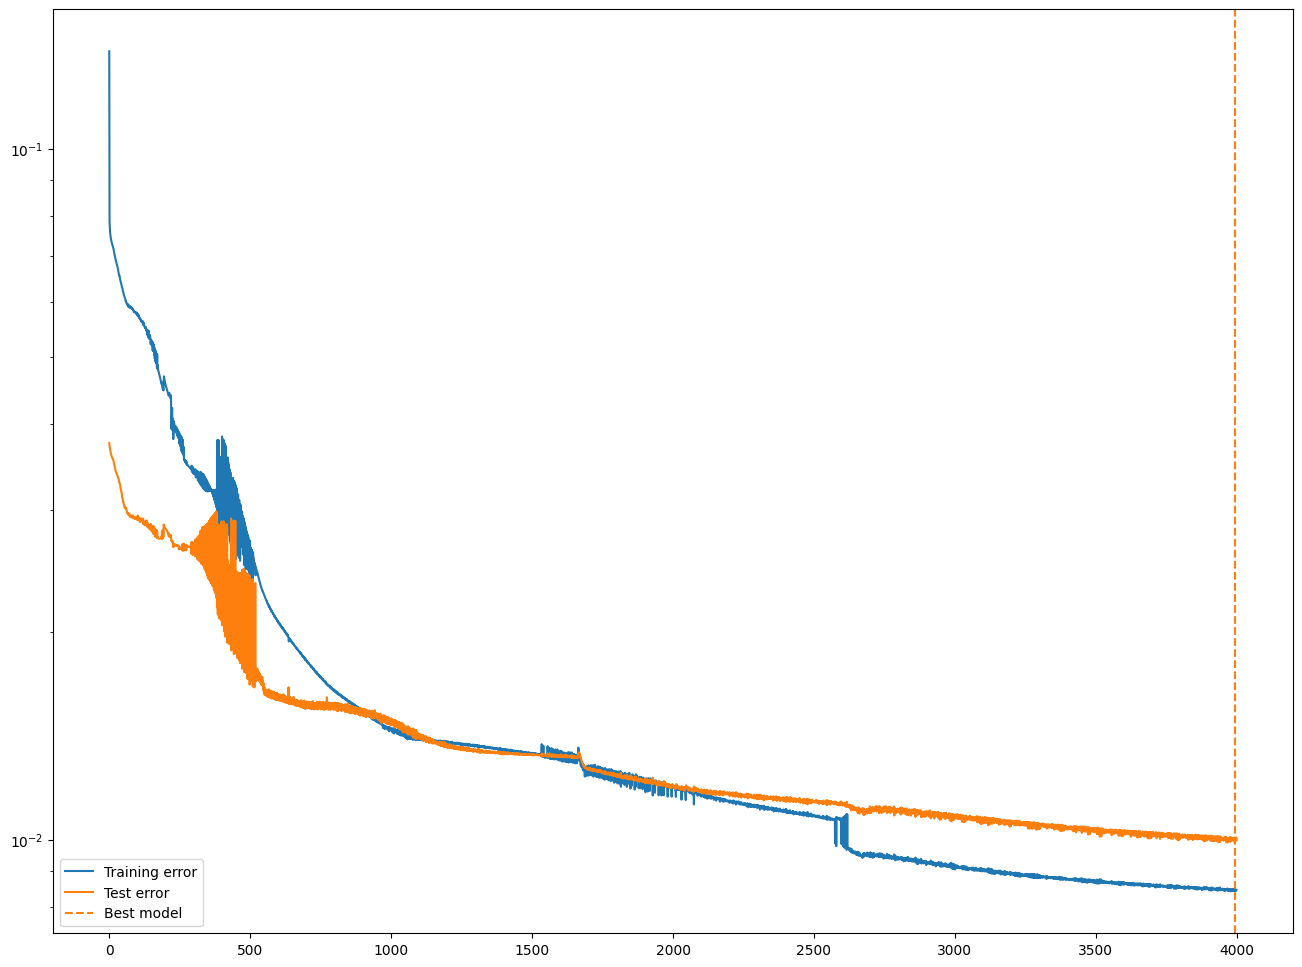

In [26]:
# evolution of training and test error
log = np.array(log)
fig, ax = plt.subplots(figsize=(16, 12))
ax.semilogy(log[:, 0], label='Training error')
ax.semilogy(log[:, 1], label='Test error')
ax.axvline(best_epoch, color='C1', linestyle='dashed', label='Best model')
ax.legend();

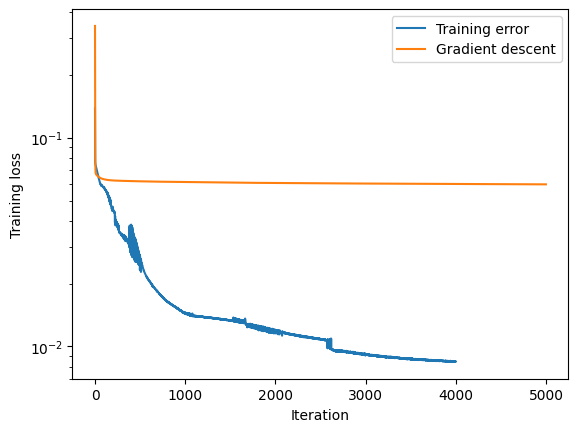

In [27]:
fig, ax = plt.subplots(dpi=100)
ax.semilogy(log[:, 0], label='Training error')
ax.plot(training_loss, label='Gradient descent')
ax.set_xlabel('Iteration')
ax.set_ylabel('Training loss')
plt.legend(loc='best');

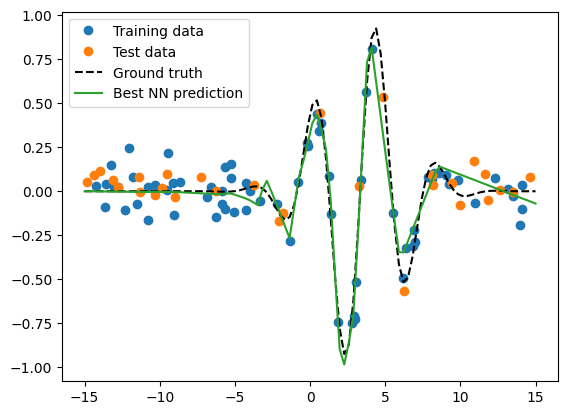

In [28]:
# final model
fig, ax = plt.subplots()
ax.plot(x_train, y_train, 'o', label='Training data')
ax.plot(x_test, y_test, 'o', label='Test data')
xx = torch.linspace(-15, 15, 100)[:, None]
model.load_state_dict(best_model)
yy = model(xx).detach().numpy()
ax.plot(xx, g(xx, 0.0), 'k--', label='Ground truth')
ax.plot(xx, yy, label='Best NN prediction')
ax.legend();

### Real-world example

https://www.learnpytorch.io/02_pytorch_classification/

https://www.kaggle.com/datasets/kaushil268/disease-prediction-using-machine-learning

https://www.kaggle.com/code/yahh0402/bank-customer-churn-prediction-using-ann

In [2]:
train_df = pd.read_csv('disease_training.csv')

# Dropping the 134th column which is unwanted
train_df = train_df.drop(train_df.columns[133], axis=1)

#remove empty rows
train_df.dropna(inplace=True)

# remove duplicates
train_df.drop_duplicates(inplace=True)

train_df

,itching,skin_rash,nodal_skin_eruptions,continuous_sneezing,shivering,chills,joint_pain,stomach_pain,acidity,ulcers_on_tongue,...,blackheads,scurring,skin_peeling,silver_like_dusting,small_dents_in_nails,inflammatory_nails,blister,red_sore_around_nose,yellow_crust_ooze,prognosis
0,1,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Fungal infection
1,0,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Fungal infection
2,1,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Fungal infection
3,1,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Fungal infection
4,1,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Fungal infection
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
402,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,1,1,Impetigo
403,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,1,1,Impetigo
405,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,1,Impetigo
406,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,1,Impetigo


In [3]:
test_df = pd.read_csv('disease_testing.csv')

#remove empty rows
test_df.dropna(inplace=True)

# remove duplicates
test_df.drop_duplicates(inplace=True)

test_df

,itching,skin_rash,nodal_skin_eruptions,continuous_sneezing,shivering,chills,joint_pain,stomach_pain,acidity,ulcers_on_tongue,...,blackheads,scurring,skin_peeling,silver_like_dusting,small_dents_in_nails,inflammatory_nails,blister,red_sore_around_nose,yellow_crust_ooze,prognosis
0,1,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Fungal infection
1,0,0,0,1,1,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Allergy
2,0,0,0,0,0,0,0,1,1,1,...,0,0,0,0,0,0,0,0,0,GERD
3,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Chronic cholestasis
4,1,1,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,Drug Reaction
5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Peptic ulcer diseae
6,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,AIDS
7,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Diabetes
8,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Gastroenteritis
9,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Bronchial Asthma


In [14]:
batch_size = 20

input_df = train_df.iloc[:,:-1]

# Use test/train split in Pytorch
x = input_df.values.astype(float)
y_str = train_df['prognosis'].values

# We can use sklearn to encode labels for the prognosis (work out how many different values there are and give each 
# one a different number
le = LabelEncoder()
y = le.fit_transform(y_str)

num_classes = len(le.classes_)
print("num_classes:", num_classes)
print("classes:", le.classes_)

# partition into 70% training data, 30% test with fixed random seed for reproducibility
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

train_data = TensorDataset(torch.Tensor(x_train), torch.Tensor(y_train).long())
train_loader = DataLoader(train_data, batch_size=batch_size)

test_data = TensorDataset(torch.Tensor(x_test), torch.Tensor(y_test).long())
test_loader = DataLoader(test_data, batch_size=batch_size)

num_classes: 41
classes: ['(vertigo) Paroymsal  Positional Vertigo' 'AIDS' 'Acne'
 'Alcoholic hepatitis' 'Allergy' 'Arthritis' 'Bronchial Asthma'
 'Cervical spondylosis' 'Chicken pox' 'Chronic cholestasis' 'Common Cold'
 'Dengue' 'Diabetes ' 'Dimorphic hemmorhoids(piles)' 'Drug Reaction'
 'Fungal infection' 'GERD' 'Gastroenteritis' 'Heart attack' 'Hepatitis B'
 'Hepatitis C' 'Hepatitis D' 'Hepatitis E' 'Hypertension '
 'Hyperthyroidism' 'Hypoglycemia' 'Hypothyroidism' 'Impetigo' 'Jaundice'
 'Malaria' 'Migraine' 'Osteoarthristis' 'Paralysis (brain hemorrhage)'
 'Peptic ulcer diseae' 'Pneumonia' 'Psoriasis' 'Tuberculosis' 'Typhoid'
 'Urinary tract infection' 'Varicose veins' 'hepatitis A']


In [9]:
x_train.shape[1]

132

Explain cross entropy loss for classification problems. 

The output nodes just output raw logits so we can apply the softmax function to get probabilities (of each outcome). We want our loss function to measure the difference between two probability distributions. 

Given sample data, predict the prognosis

In [11]:
# INTERACTIVE

# call model with sample data to get prediction and compare to real label (take from test set)

loss_fn = nn.CrossEntropyLoss()
learning_rate = 1e-1

torch.manual_seed(1) # reproducible weights
model = nn.Sequential(nn.Linear(x_train.shape[1], 96),                # Re-define model (new random weights)
                  nn.ReLU(), nn.Linear(96, 64), nn.ReLU(),
                  nn.Linear(64, num_classes))
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

In [65]:
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    total_loss = 0.0
    for batch, (x, y) in enumerate(dataloader):
        optimizer.zero_grad()        
        y_pred_logits = model(x)
        # y_pred = torch.softmax(y_pred_logits, dim=1).argmax(dim=1) # go from logits -> prediction probabilities -> prediction labels
        # y = y.float()
        # y_pred = y_pred.float()
        loss = loss_fn(y_pred_logits,y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    train_err = total_loss/num_batches
    return train_err

def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss = 0.0
    with torch.no_grad():
        for x, y in dataloader:
            y_pred_logits = model(x)
            test_loss += loss_fn(y_pred_logits, y).item()
    test_err = test_loss / num_batches
    return test_err

test(train_loader, model, loss_fn)

0.00012447814515326172

In [66]:
log = []
checkpoints = []
min_test_err = np.inf

pbar = range(1000)
for epoch in pbar:
    train_err = train(train_loader, model, loss_fn, optimizer)
    test_err  = test(test_loader, model, loss_fn)
    log.append([train_err, test_err])
    if test_err < min_test_err:
        min_test_err = test_err
        best_epoch = epoch
        best_model = copy.deepcopy(model.state_dict())
    # pbar.set_description(f"{epoch=:5d} Training Loss {train_err:>8f} Test Loss {test_err:>8f}")
    if epoch % 50 == 0:
        # checkpoints.append(copy.deepcopy(model.state_dict()))
        print(train_err,test_err)

0.00012454139057528944 0.0013780167028016876
0.00012187381449061482 0.0013612851107609458
0.0001192942240427678 0.001345143096841639
0.00011683134387287562 0.0013295672870299313
0.00011445186520666958 0.0013145198827260174
0.00011216358227382164 0.0012999089740333147
0.0001099709378859888 0.0012857827750849538
0.00010784519543869045 0.0012720855957013555
0.0001058040903584557 0.0012587827659444883
0.00010383172530754773 0.0012457246739359107
0.00010192673436484675 0.0012331093530519865
0.00010007841571608039 0.0012207818181195762
9.830434506651587e-05 0.0012088262774341274
9.658099329849043e-05 0.0011972447973676026
9.491554059283002e-05 0.001185933782835491
9.331135312934818e-05 0.0011749251279979944
9.17519321144657e-05 0.0011642094250419177
9.02328341768365e-05 0.0011537599566509016
8.875987763391234e-05 0.0011435087799327448
8.733917142168278e-05 0.0011335965064063203


In [ ]:
# predict value for unseen data

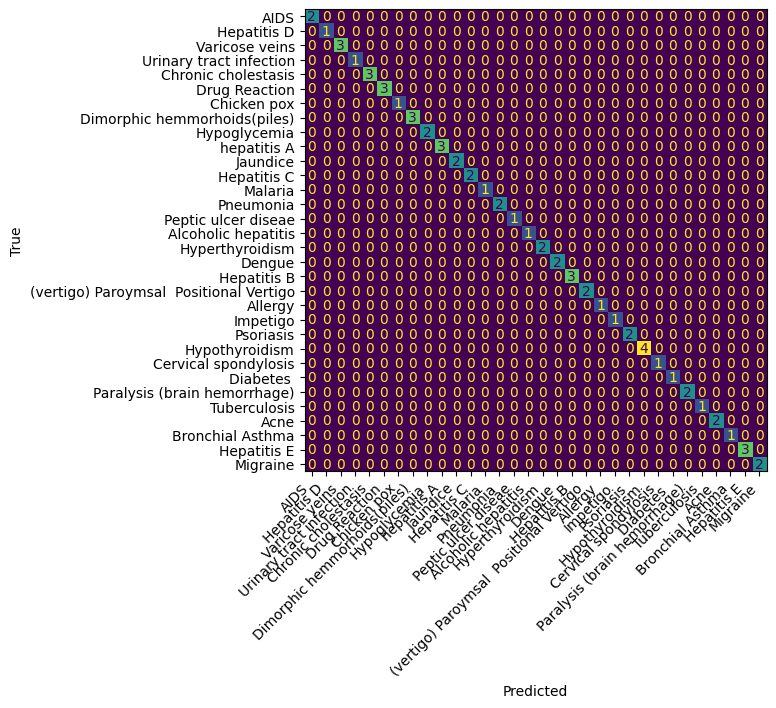

In [138]:
# confusion matrix
import sklearn
import warnings
warnings.filterwarnings('ignore')

model.eval()
all_preds = []
all_labels = []
with torch.no_grad():
    for xb, yb in test_loader:
        logits = model(xb)
        preds = logits.argmax(dim=1).cpu().numpy()
        all_preds.append(preds)
        all_labels.append(yb.numpy())
all_preds = np.concatenate(all_preds)
all_labels = np.concatenate(all_labels)

# print(set(le.inverse_transform(all_labels)))

confusion_matrix = sklearn.metrics.confusion_matrix(le.inverse_transform(all_labels), le.inverse_transform(all_preds))
cm_display = sklearn.metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = set(le.inverse_transform(all_labels)))

ax = cm_display.plot(colorbar=False)
# plt.figure(figsize=(14,14))
plt.rcParams["figure.figsize"] = (8,8)
plt.xlabel("Predicted") 
plt.ylabel("True")
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.show()


Then introduce the idea of a confusion matrix for this type of problem

Discuss whether we can use our model for treating actual patients:

- Does not contain knowledge of every disease
- Does not factor age, sex, race, smoker etc. which can increase chances of certain diseases
- Relatively small sample size
- Medicine is complex - often will treat for easy conditions first to rule them out
- Some diagnostic measures missing from training data
- Is the data accurate? Could have some false positives and false negatives? 

Many more neural network architectures are possible: graph, residual, convolutional... 